In [1]:
# import libraries we need
%pylab inline
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Disable all GPUs
try:
    tf.config.set_visible_devices([], 'GPU')
    visible_devices = tf.config.get_visible_devices()
    for device in visible_devices:
        assert device.device_type != 'GPU'
except:
    pass

# Set the number of threads
intra = 2  # threads used within an individual op for parallelism
inter = 2  # threads used for parallelism between independent operations
tf.config.threading.set_intra_op_parallelism_threads(intra)
tf.config.threading.set_inter_op_parallelism_threads(inter)

*This is for simulating correlation data using Monte Carlo.*

First, we make random choice to decide which light source is used.

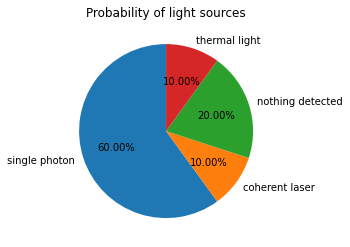

In [25]:
# define light sources

Ndetection = int(10e6)    # total detections
Nbin = 401                # total time bins
N = Ndetection / Nbin     # average co-detections per bin

bin_array = tf.range(Nbin//2 * (-1) ,Nbin//2+1,delta=1,dtype=float32)
bin_n = tf.constant(np.linspace(min(bin_array),-1,Nbin//2),dtype=float32)
bin_p = tf.constant(np.linspace(1,max(bin_array),Nbin//2),dtype=float32)
exp_rate = 1.       # exponential rate
n = 1              # identical single photon emitters
zeroth = 1 - (1/n)  # correlation at zero delay


p_sps = 0.6         #  probability of a single photon source
p_laser = 0.1      # probability of a coherent laser source
p_non = 0.2         # probability of getting nothing / 2nd photon is not in the range of abs time range
p_ther = 0.1       # probability of a thermal light source

lightsource = {
    'single photon': p_sps,
    'coherent laser': p_laser,
    'nothing detected': p_non,
    'thermal light': p_ther,
    }

#source_dist = tf.random.categorical(tf.math.log([[i for i in lightsource.values()]]), Ndetection)
#[len(np.where(source_dist[0].numpy()==i)[0])for i in range(len(lightsource))]


fig,ax = plt.subplots(1,1)
ax.pie([i for i in lightsource.values()],
       labels=[i for i in lightsource.keys()],autopct='%1.2f%%',startangle=90)
ax.set_title('Probability of light sources')
fig.show()

#plt.polar(source[0].numpy(),label='event')
#plt.ylabel('event type',fontsize=15)
#plt.xticks([0,1,2],['single photon','laser','nothing'])
#plt.legend(loc=(0,1.02))


---
# single photon source
We first simulate the single photon source case. For an ideal single photon emitter, it's not possible for two detectors to detect photons at the same time, resulting a dip (zero probability) at zero time delay while equal probability for all other time bins. 

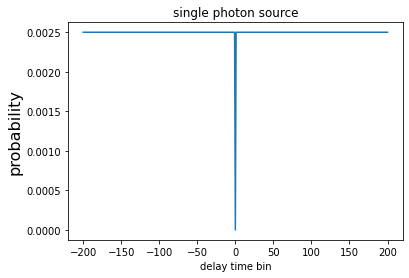

In [7]:
# single photon distribution

sps_dist = tfd.MixtureSameFamily(
    mixture_distribution = 
    tfd.Categorical(probs=[bin_n.shape[0]/(Nbin+0),0/Nbin, bin_p.shape[0]/(Nbin+0)]),
    # probability to get the second photon at a time slot
    
    components_distribution = 
    #tfd.Exponential(rate=exp_rate),
    tfd.Uniform(low=[min(bin_array),0.,1],high=[0,0.,max(bin_array)+1])
                       )

sps_prob = sps_dist.prob(bin_array+0.2)
#sps_prob = tf.concat([sps_prob[0],[0],sps_prob[1]],0)
fig, ax = plt.subplots()
ax.plot(bin_array,sps_prob)
ax.set_title('single photon source')
ax.set_xlabel('delay time bin')
ax.set_ylabel('probability',size=16)
fig.show()


### test the single photon case

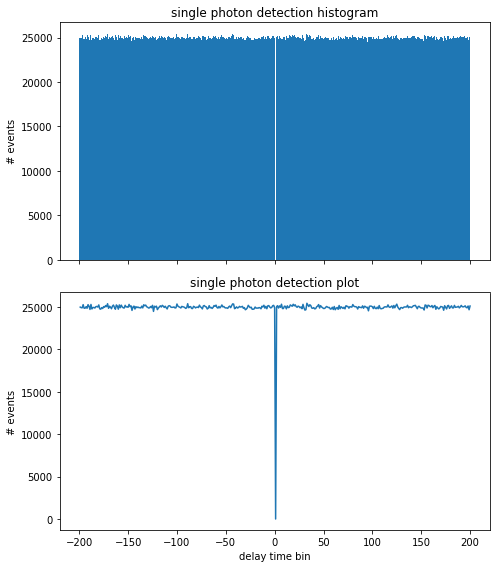

In [8]:
# sampling from the distribution
counts = Ndetection
samples = sps_dist.sample(counts)
#samples = tf.cast(sps_dist.sample(counts),dtype=int32)

fig, axs = plt.subplots(2,1,sharex=True,figsize=(7,8))
#f1 = plt.figure(1)
histoinfo=axs[0].hist(samples.numpy(), bins=np.ndarray.tolist(bin_array.numpy()) )  
axs[0].set_title('single photon detection histogram')
axs[0].set_ylabel('# events')

#f2 = plt.figure(2)
axs[1].plot(histoinfo[1][1:],histoinfo[0][0:])
axs[1].set_title('single photon detection plot')
axs[1].set_xlabel('delay time bin')
axs[1].set_ylabel('# events')
fig.show()

fig.tight_layout()

---
### nothing detected
The case no photon is detected, which is trivial since probabilities for all time bins are zero.

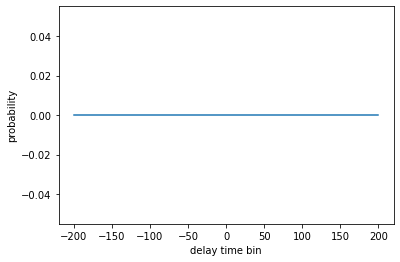

In [9]:
# no photons detected

non_dist = tfd.Uniform(low=10000.,high=10000.)
non_prob = non_dist.prob(bin_array)
fig, ax = plt.subplots(1,1)
ax.plot(bin_array,non_prob)
ax.set_xlabel('delay time bin')
ax.set_ylabel('probability')
fig.show()


---
### coherent laser
Here we simulate a perfectly coherent light source and the temporal distrubition of detecting the second photon is uniform.

In [10]:
# coherent laser
laser_dist = tfd.Uniform(low=min(bin_array),high=max(bin_array)+1)
laser_prob = laser_dist.prob(bin_array)

# sampling from the distribution
samples = laser_dist.sample(counts)

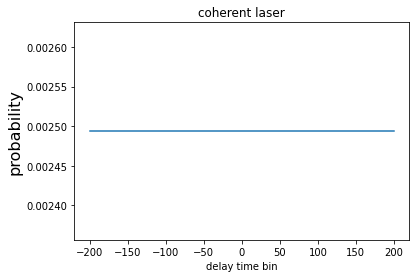

<Figure size 432x288 with 0 Axes>

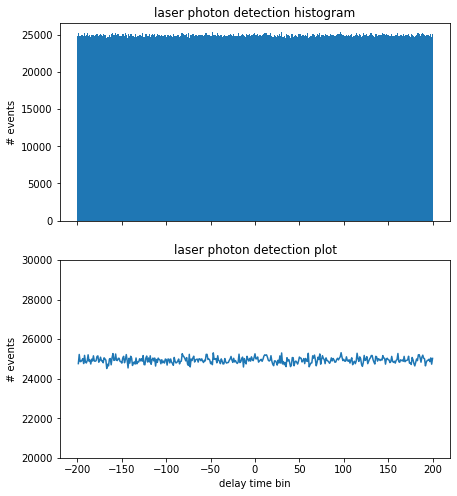

In [11]:
# plot the result
plt.figure(1)
plt.plot(bin_array,laser_prob)
plt.title('coherent laser')
plt.xlabel('delay time bin')
plt.ylabel('probability',size=16)
plt.show()

plt.figure(2)
fig, axs = plt.subplots(2,1,sharex=True,figsize=(7,8))
histoinfo=axs[0].hist(samples.numpy(), bins=np.ndarray.tolist(bin_array.numpy()) )  
axs[0].set_title('laser photon detection histogram')
axs[0].set_ylabel('# events')
fig.show()

axs[1].plot(histoinfo[1][1:],histoinfo[0][0:])
axs[1].set_title('laser photon detection plot')
axs[1].set_xlabel('delay time bin')
axs[1].set_ylabel('# events')
axs[1].set_ylim(20000,30000)
plt.show()

fig.tight_layout()



---
### thermal light source
A thermal source has maximum correlations for a small value of $\tau$, since it has higher probability to detect the second photon right after the first one is detected. For large $\tau$, this correlation vanishes hence the $g^{(2)}$ goes to zero.


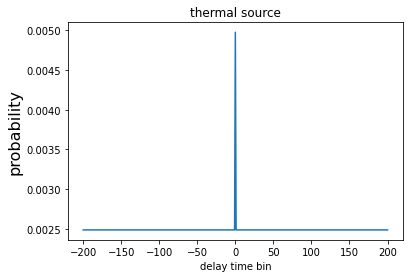

In [12]:
# thermal source

ther_dist = tfd.MixtureSameFamily(
    mixture_distribution = 
    tfd.Categorical(probs=[bin_n.shape[0]/(Nbin+1),2/(Nbin+1), bin_p.shape[0]/(Nbin+1)]),
    # probability to get the second photon at a time slot
    
    components_distribution = 
    tfd.Uniform(low=[min(bin_array),0.,1],high=[0,1.,max(bin_array)+1])
                       )

ther_prob = ther_dist.prob(bin_array+0.2)
fig, ax = plt.subplots()
ax.plot(bin_array,ther_prob)
ax.set_title('thermal source')
ax.set_xlabel('delay time bin')
ax.set_ylabel('probability',size=16)
fig.show()


### test the thermal source simulator

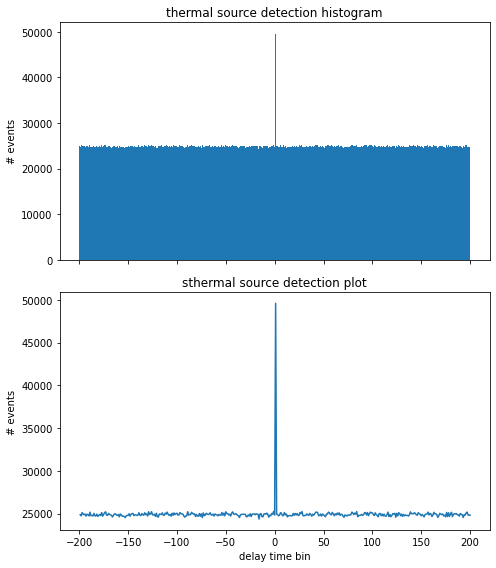

In [13]:
# sampling from the distribution
counts = Ndetection
samples = ther_dist.sample(counts)
#samples = tf.cast(sps_dist.sample(counts),dtype=int32)

fig, axs = plt.subplots(2,1,sharex=True,figsize=(7,8))
#f1 = plt.figure(1)
histoinfo=axs[0].hist(samples.numpy(), bins=np.ndarray.tolist(bin_array.numpy()) )  
axs[0].set_title('thermal source detection histogram')
axs[0].set_ylabel('# events')

#f2 = plt.figure(2)
axs[1].plot(histoinfo[1][1:],histoinfo[0][0:])
axs[1].set_title('sthermal source detection plot')
axs[1].set_xlabel('delay time bin')
axs[1].set_ylabel('# events')
fig.show()

fig.tight_layout()

---
## Combine above situations

In [26]:
# combine all light source distributions
total_dist = tfd.Mixture(
    cat = tfd.Categorical(probs=[i for i in lightsource.values()]),
    components = [sps_dist,laser_dist,non_dist,ther_dist] )

# sampling from the overall distribution
mixsamples = total_dist.sample(counts)
#total_dist.sample(counts)

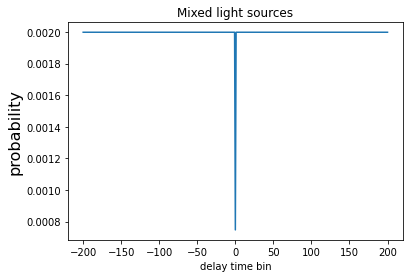

In [27]:
# plot the total probability 
fig, ax = plt.subplots()
ax.plot(bin_array,total_dist.prob(bin_array+0.2))
ax.set_title('Mixed light sources')
ax.set_xlabel('delay time bin')
ax.set_ylabel('probability',size=16)
fig.show()


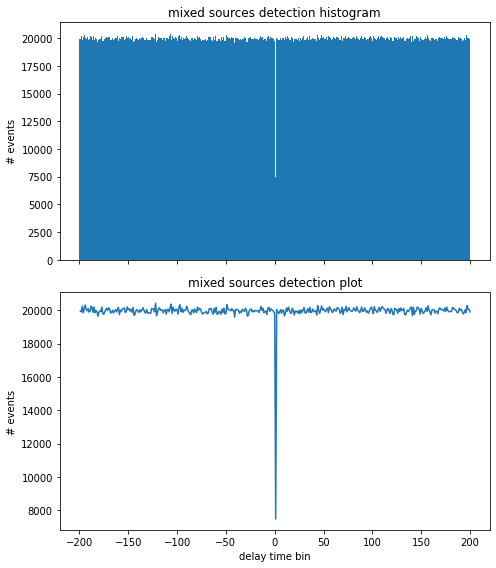

In [28]:
# plot sampling histogram

fig, axs = plt.subplots(2,1,sharex=True,figsize=(7,8))
#f1 = plt.figure(1)
mixhistoinfo=axs[0].hist(mixsamples.numpy(), bins=np.ndarray.tolist(bin_array.numpy()) )
axs[0].set_title('mixed sources detection histogram')
axs[0].set_ylabel('# events')

#f2 = plt.figure(2)
axs[1].plot(mixhistoinfo[1][1:],mixhistoinfo[0][0:])
axs[1].set_title('mixed sources detection plot')
axs[1].set_xlabel('delay time bin')
axs[1].set_ylabel('# events')
fig.show()

fig.tight_layout()

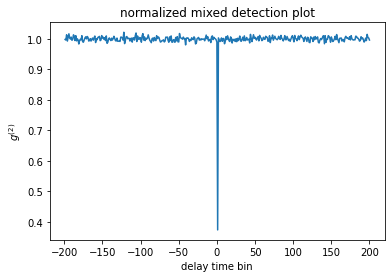

In [30]:
# normalize the above figure
mixcount = mixhistoinfo[0][0:]
mixmean = np.average(mixcount[np.argsort(mixcount)[1:]])
fig, ax = plt.subplots()
ax.plot(mixhistoinfo[1][1:],mixcount/mixmean)
ax.set_title('normalized mixed detection plot')
ax.set_xlabel('delay time bin')
ax.set_ylabel(r'$g^{(2)}$')
fig.show()